In [12]:
import os
os.environ["TF_FORCE_GPU_ALLOW-GROWTH"] = "true"

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.metrics import Mean
from tensorflow.keras.metrics import SparseCategoricalAccuracy  

## 1. 활성화 함수가 Sigmoid인 경우, Gradient Vanishing 확인

In [13]:
train_ds, ds_info = tfds.load(name='mnist',
                              shuffle_files=True,
                              as_supervised=True,
                              split='train',
                              with_info=True)

In [14]:
def normalization(images, labels):
    images = tf.cast(images, tf.float32) / 255.
    return [images, labels]

train_batch_size = 10
train_ds = train_ds.map(normalization).batch(train_batch_size)

train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

print(images.shape, labels.shape)

(10, 28, 28, 1) (10,)


In [15]:
n_layer = 7
cmap = cm.get_cmap('rainbow', lut=n_layer+1)
units = [10]*n_layer  # 각 layer에 들어갈 unit 값 저장

print(units)

[10, 10, 10, 10, 10, 10, 10]


In [16]:
model = Sequential()
model.add(Flatten())
for layer_idx in range(n_layer-1):
    model.add(Dense(units=units[layer_idx], activation='sigmoid'))
model.add(Dense(units=10, activation='softmax'))

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [17]:
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD()

In [18]:
with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
gradients = tape.gradient(loss, model.trainable_variables)

print(type(gradients))
print(len(gradients))  # 총 7개의 layer에 weight + bias가 들어있음
print(type(gradients[0]))
print(gradients[0].shape)  # 0번째 layer(flatten 제외)에 대한 gradients 행렬의 크기
print(model.layers[1].get_weights()[0].shape)  # 1번째 layer(flatten 포함)에 대한 기울기 행렬의 크기

<class 'list'>
14
<class 'tensorflow.python.framework.ops.EagerTensor'>
(784, 10)
(784, 10)


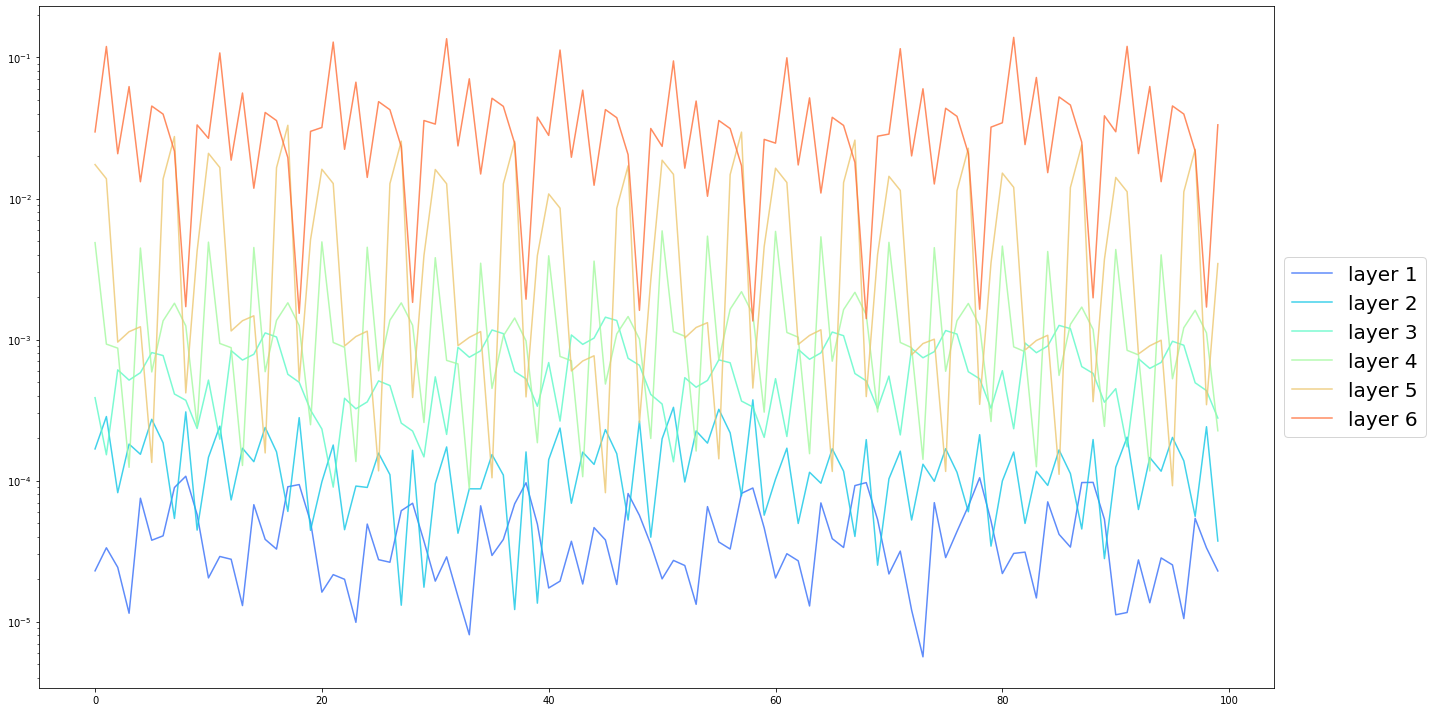

In [19]:
## 각 layer에서의 가중치에 대한 gradient 확인
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:   # 첫번째 레이어는 제외(기울기만 7840개여서 그래프를 그리기 어려움)
        grad_abs = np.abs(grad.numpy().flat)
        ax.plot(grad_abs,
                label='layer {}'.format(grad_idx),
                color=cmap(grad_idx),
                alpha=0.8)
ax.legend(bbox_to_anchor=(1, 0.5),
          loc='center left',
          fontsize=20)
fig.tight_layout()

=> 앞 쪽의 layer로 갈수록 gradient가 감소하는 문제가 나타남

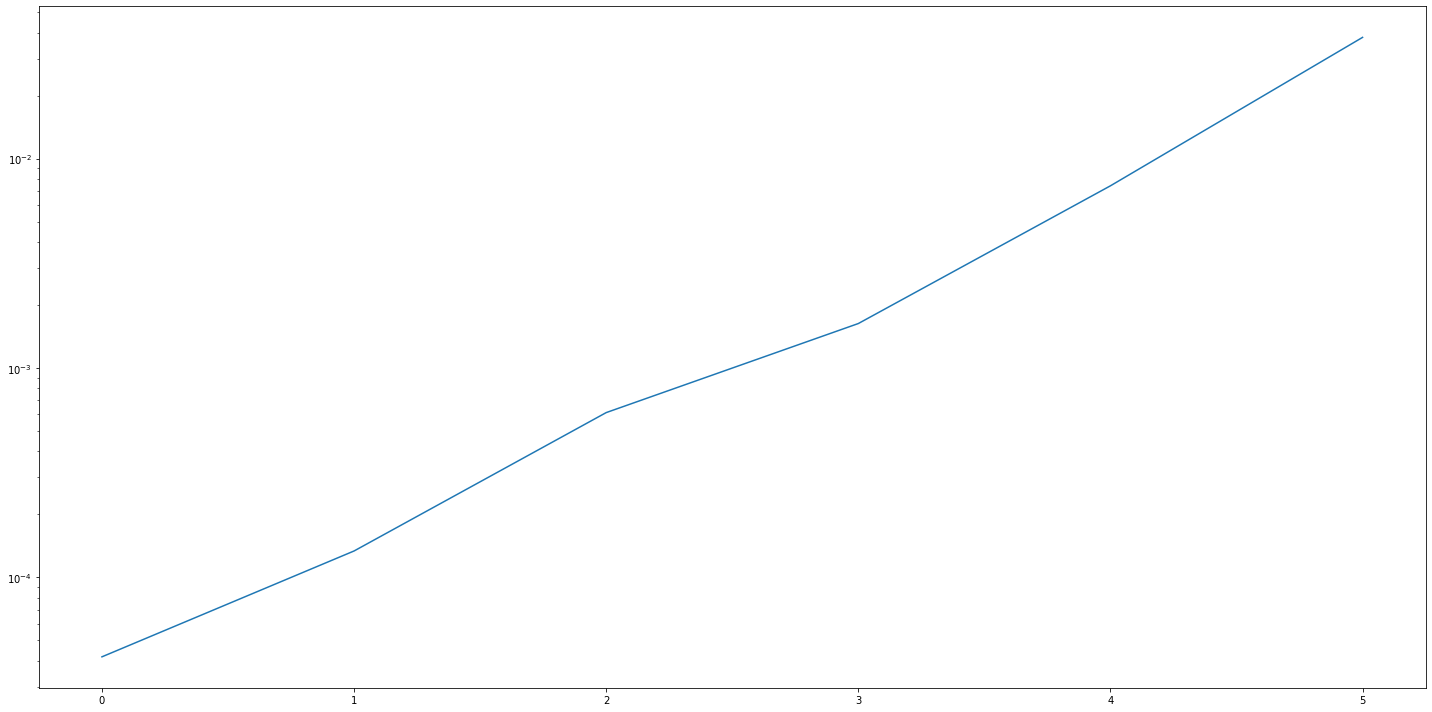

In [20]:
## 각 layer에서의 gradient의 평균을 계산
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
grad_means = []
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        grad_means.append(np.mean(grad_abs))

ax.plot(grad_means)

fig.tight_layout()

=> 앞쪽의 layer일수록 gradients의 평균값이 작아지는 것을 확인 가능

## 2. 활성화 함수가 relu인 경우

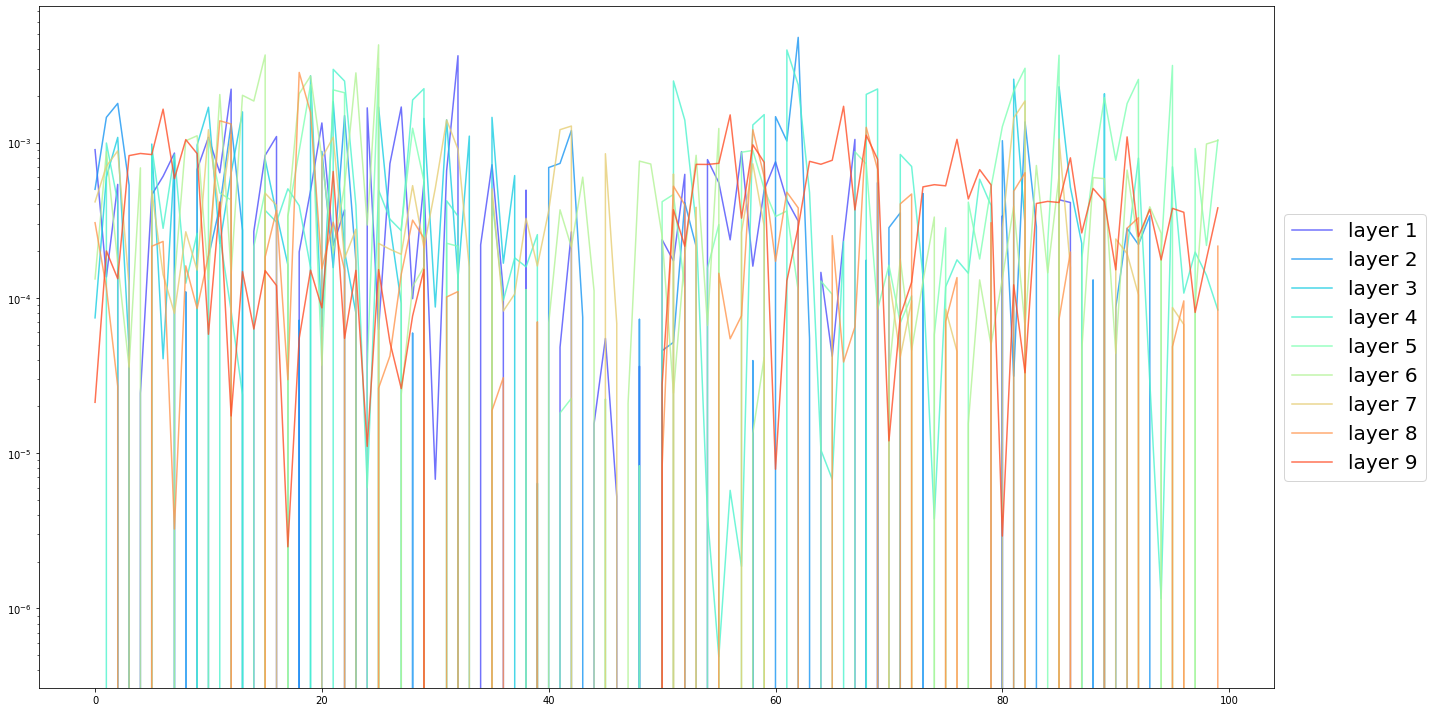

In [37]:
model = Sequential()
model.add(Flatten())
for layer_idx in range(n_layer-1):
    model.add(Dense(units=units[layer_idx], activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.build(input_shape=(None, 28, 28, 1))

train_batch_size = 10
train_ds = train_ds.map(normalization).batch(train_batch_size)

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD()

with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
gradients = tape.gradient(loss, model.trainable_variables)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        ax.plot(grad_abs,
                label='layer {}'.format(grad_idx),
                color=cmap(grad_idx),
                alpha=0.8)
ax.legend(bbox_to_anchor=(1, 0.5),
          loc='center left',
          fontsize=20)
fig.tight_layout()

=> 초기 layer(layer1, layer2, ...)들에 대해서도 gradient가 살아있음을 확인 가능  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;값이 0이 되는 dying relu를 제외하면 값들이 10^{-3} 이상에 몰려있음

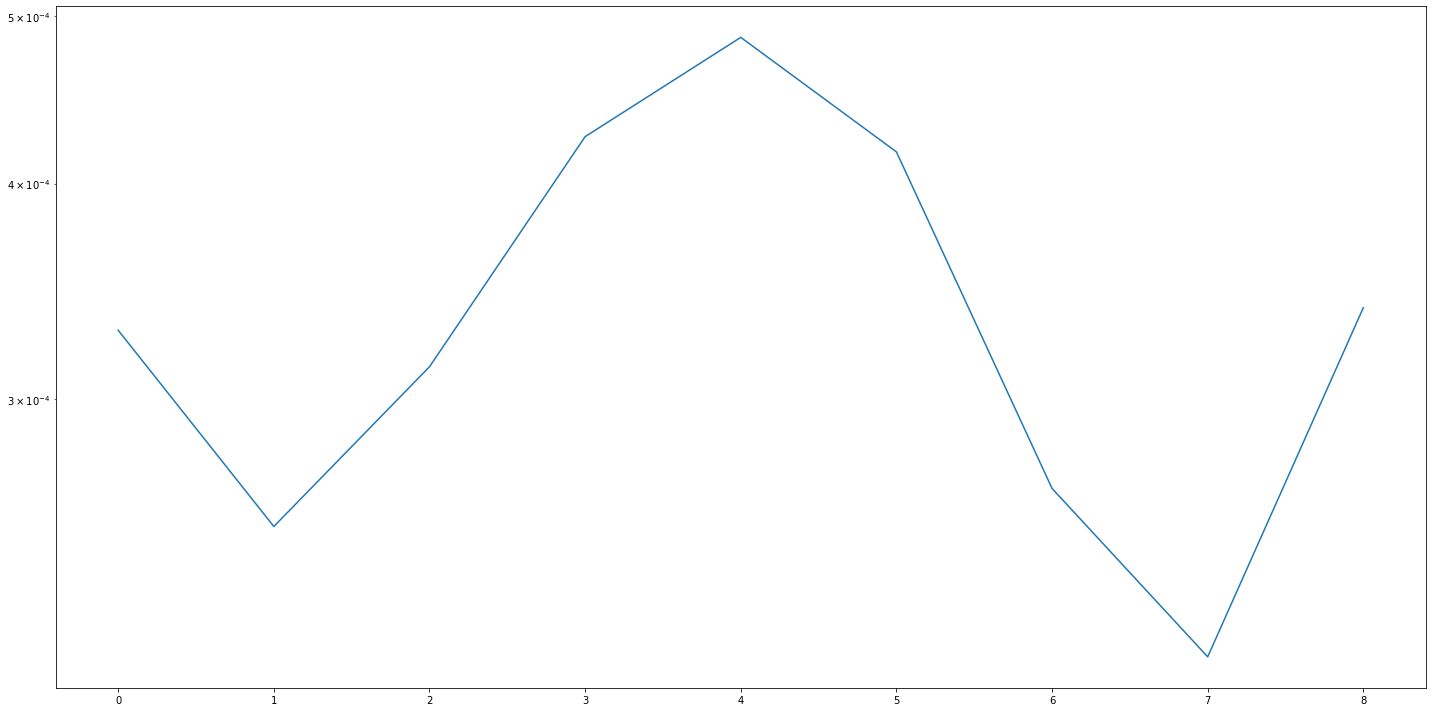

In [40]:
## 각 layer에서의 gradient의 평균을 계산
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
grad_means = []
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        grad_means.append(np.mean(grad_abs))

ax.plot(grad_means)

fig.tight_layout()

=> 앞쪽 layer로 가도 gradient가 살아있어서, 계속 학습이 이루어진 것을 확인 가능  
&nbsp;&nbsp;&nbsp;&nbsp; (중간에 값이 작아지는 것은 random한 효과)

## 3. 활성화 함수가 tanh인 경우

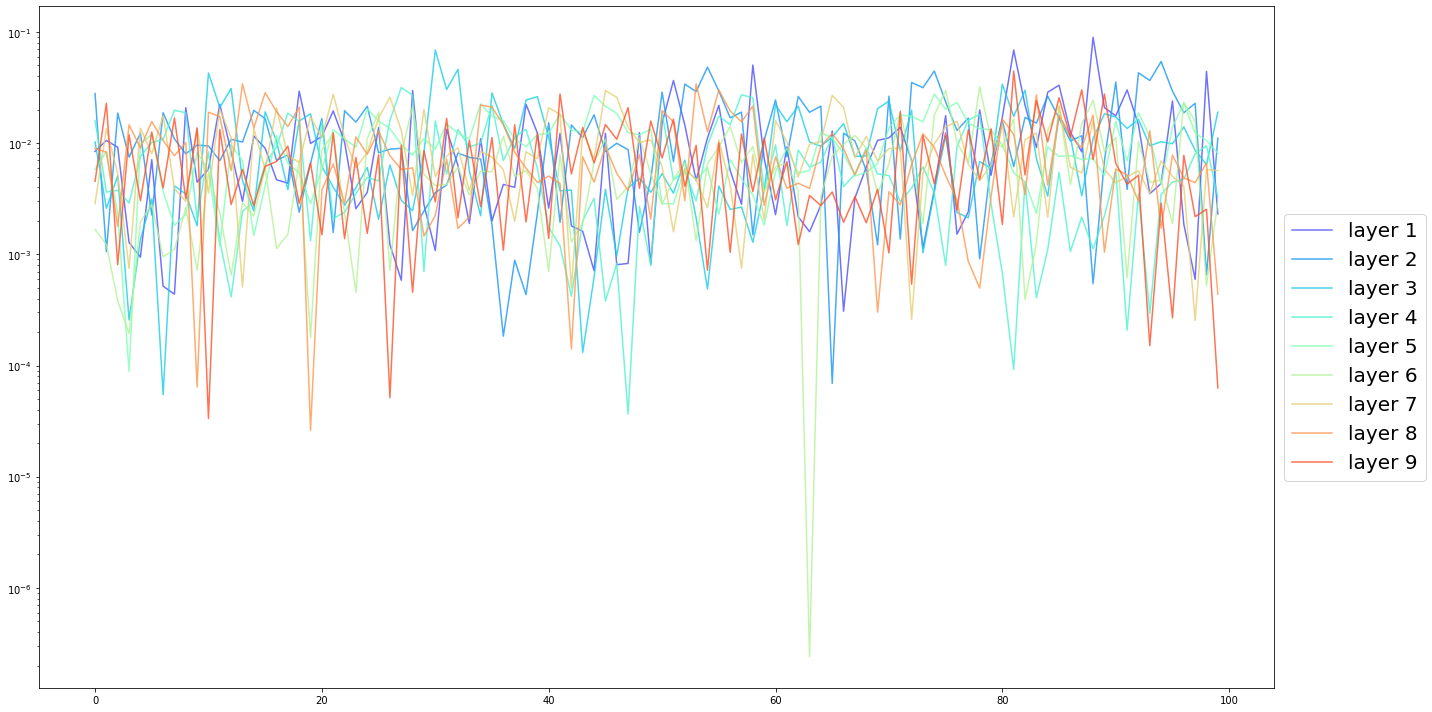

In [32]:
n_layer = 10
cmap = cm.get_cmap('rainbow', lut=n_layer+1)
units = [10]*n_layer
model = Sequential()
model.add(Flatten())

for layer_idx in range(n_layer-1):
    model.add(Dense(units=units[layer_idx], activation='tanh'))
model.add(Dense(units=10, activation='softmax'))

train_batch_size = 10
train_ds = train_ds.map(normalization).batch(train_batch_size)

loss_object = SparseCategoricalCrossentropy()

with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
gradients = tape.gradient(loss, model.trainable_variables)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        ax.plot(grad_abs,
                label='layer {}'.format(grad_idx),
                color=cmap(grad_idx),
                alpha=0.8)
ax.legend(bbox_to_anchor=(1, 0.5),
          loc='center left',
          fontsize=20)
fig.tight_layout()

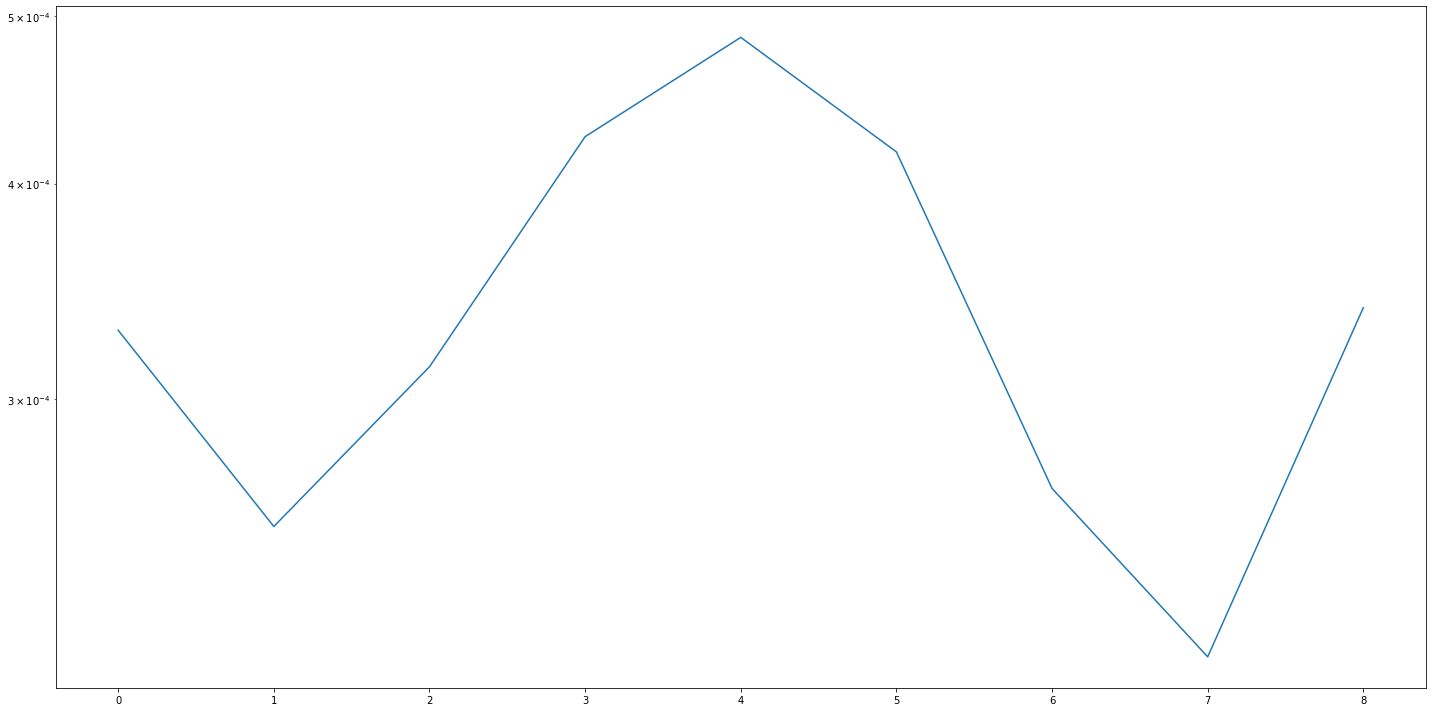

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale('log')
grad_means = []
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        grad_means.append(np.mean(grad_abs))

ax.plot(grad_means)

fig.tight_layout()

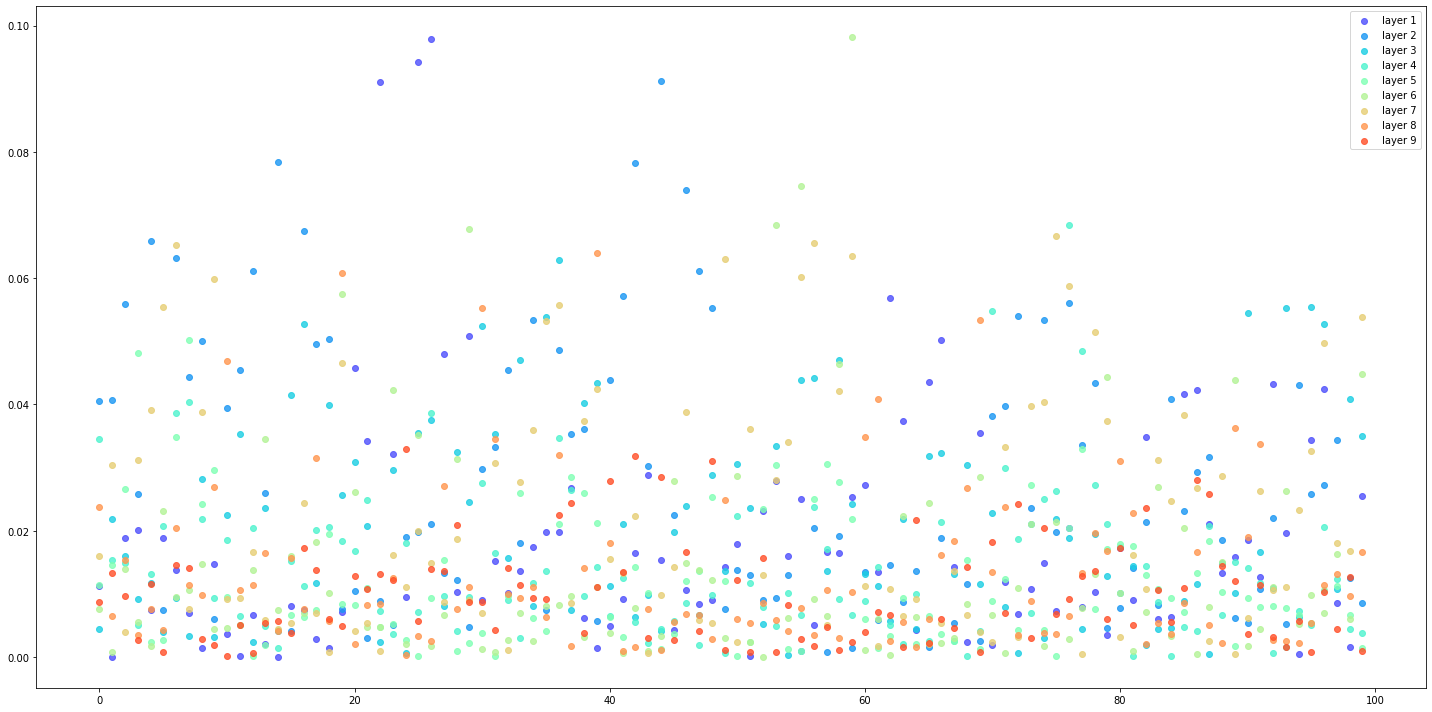

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
# ax.set_yscale('log')
grad_means = []
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        x_range = np.arange(len(grad_abs))
        ax.scatter(x_range, grad_abs,
            label='layer {}'.format(grad_idx),
            color=cmap(grad_idx),
            alpha=0.8)
ax.legend()
fig.tight_layout()